# 300对冲

# 定义相关函数

In [1]:
import pandas as pd
from datetime import datetime

import rqalpha as rqa
import rqalpha_plus

import rqdatac as rqd
rqd.init()

import rqoptimizer as rqo
from rqoptimizer.utils import stock_select,TotalStockCountTarget


# ==========================生成目标组合===========================


_ALPHA_SCORE_CACHE = None
def get_alpha_score(date, path=None):
    """从本地文件读取指定日期的alpha分数"""
    # 以一个全局变量作为缓存, 一次性将所有数据读入, 减少文件IO
    global _ALPHA_SCORE_CACHE
    if _ALPHA_SCORE_CACHE is None:
        df = pd.read_csv(path, header=None)
        df[0] = df[0].astype(str)
        df.columns = ['date','code','factor']
        df['code'] = df['code'].map(
            lambda x: x.replace('SZ', 'XSHE') if x[-2:] == 'SZ' else x.replace('SH', 'XSHG'))
        df.set_index(['date', 'code'], inplace=True)
        _ALPHA_SCORE_CACHE = df
    if date in _ALPHA_SCORE_CACHE.index.levels[0]:
        return _ALPHA_SCORE_CACHE.loc[date].squeeze()
    else:
        return pd.Series()

    
def get_target_stock(date,stock_num):
    """选取alpha分数最高的股票"""
    score = get_alpha_score(date)
     # 中证800成分股
    component = rqd.index_components('000906.XSHG', date)
    score_index = score.index.tolist()
    # 取交集
    score = score.loc[list(set(component).intersection(score_index))]
    # 优先级都相同,设为0
    pool = pd.Series(0,index=score.index)
    targets = [TotalStockCountTarget(stock_num)]
    target_stock = stock_select(pool, targets, date, score, benchmark=None)
    return target_stock, score


def get_target_portfolio(context,target_stock,date,score,benchmark):
    """按照产品设置, 计算目标组合"""
    # 定义目标函数和约束条件
    objective = rqo.MaxIndicator(score)
    
    # 指定行业约束
    industry_constraints = rqo.WildcardIndustryConstraint(
                                exclude=None,
                                lower_limit=-0.03,
                                upper_limit=0.03,
                                relative=True,
                                hard=False,
                                classification=rqo.IndustryClassification.ZX)
    # 风格约束
    style_constraints = rqo.StyleConstraint(
                        'size', lower_limit=-0.1, upper_limit=0.1, relative=True, hard=False)
    
    # 跟踪误差约束
    trackingerro_constraints = rqo.TrackingErrorLimit(upper_limit=0.05, hard=False)

    constraints = [industry_constraints, style_constraints,trackingerro_constraints]
    # 个股绝对权重
    bnds = {'*':(0,0.01)}
    target_portfolio = rqo.portfolio_optimize(target_stock,date, 
                                       benchmark=benchmark, 
                                       objective=objective,
                                       cons=constraints,
                                       bnds=bnds) 
    # 由于精度问题, 优化结果可能包含非常接近0的股票权重, 在此直接舍去
    return target_portfolio.loc[lambda x:x!=0]

# ========================回测相关==========================

def _should_rebalance(context):
    """判断当日是否需要调仓"""
    # 若当日的读取的alpha分数非空, 则执行调仓
    today = context.now.strftime('%Y%m%d')
    score = get_alpha_score(today, context.alpha_score_path)
    return score.empty


def handle_bar(context, bar_dict):
    """按照调仓条件进行调仓"""
    if _should_rebalance(context):
        return
    today = context.now.strftime('%Y%m%d')
    target_stock,score = get_target_stock(today,context.stock_num)
    target_portfolio = get_target_portfolio(context,target_stock,today,score,context.benchmark)
    print(target_portfolio.shape)
    rebalance(context,bar_dict,target_portfolio)


def rebalance(context, bar_dict, target_portfolio):
    """根据目标组合, 计算其与当前持仓的差额, 进行调仓"""
    positions = context.stock_account.positions
    for order_book_id in positions:
        if order_book_id not in target_portfolio:
            rqa.api.order_to(order_book_id, 0)

    # 对每个股票计算目标价值和当前价值的差值
    # 差值为正的是买单, 反之为卖单
    capital = context.stock_account.total_value * (1 - context.cash_cushion)
    to_sell, to_buy = {}, {}

    def _money_for_one_lot(
        order_book_id): return bar_dict[order_book_id].close * 100

    for order_book_id, weight in target_portfolio.items():
        # 股票目标价值
        target_value = capital * weight
        # 目标和现有之差
        gap = target_value - positions[order_book_id].market_value
        # 买卖至少大于1手股票价值
        if abs(gap) < _money_for_one_lot(order_book_id):
            continue
        elif gap > 0:
            to_buy[order_book_id] = gap
        else:
            to_sell[order_book_id] = gap

    # 避免流动性问题,先卖出后买入
    for order_book_id, value in to_sell.items():
        rqa.api.order_value(order_book_id, value)
    for order_book_id, value in to_buy.items():
        rqa.api.order_value(order_book_id, value)

# 回测设置
- 起止日期: 由alpha分数文件`alphaAx_全部A股_基础池取交集_F22_LHZX.csv`确定
- 假设每个交易日开盘可获得股票的alpha分数, 以当日收盘价买入
- 当出现约束过于严格无法优化时, 放宽约束重新求解

In [12]:
config = {
    "base": {
        "start_date": '2017-01-26',
        "end_date": '2020-08-04',
        "frequency": '1d',
        "accounts": {"stock": 1e8},
        "data_bundle_path":r'C:\Users\Administrator\.rqalpha-plus\bundle'
    },

    "mod": {
        "sys_analyser": {
            "enabled": True,
            "plot": True,
            "benchmark": '000300.XSHG',
        },
    },

    "extra": {
        "log_level": 'error',
        "context_vars": {
            'benchmark':'000300.XSHG',
            'cash_cushion': 0.005,
            'stock_num': 700,
            # 用context_var机制, 让context访问到alpha score的文件路径
            'alpha_score_path':'alphaAx_全部A股_基础池取交集_F22_LHZX.csv'
        },
    },
}

WARN: aa_init returned NULL, no acceleration applied.
WARN: aa_init returned NULL, no acceleration applied.
WARN: aa_init returned NULL, no acceleration applied.
WARN: aa_init returned NULL, no acceleration applied.
WARN: aa_init returned NULL, no acceleration applied.
WARN: aa_init returned NULL, no acceleration applied.
WARN: aa_init returned NULL, no acceleration applied.
WARN: aa_init returned NULL, no acceleration applied.
WARN: aa_init returned NULL, no acceleration applied.
WARN: aa_init returned NULL, no acceleration applied.
WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\user_module.py:99: OptimizerWarning: 达到最大迭代次数，但仍未达到所需精度，可能会导致某些约束不能满足


WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\user_module.py:99: OptimizerWarning: 达到最大迭代次数，但仍未达到所需精度，可能会导致某些约束不能满足


WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\user_module.py:99: OptimizerWarning: 达到最大迭代次数，但仍未达到所需精度，可能会导致某些约束不能满足


WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\user_module.py:99: OptimizerWarning: 达到最大迭代次数，但仍未达到所需精度，可能会导致某些约束不能满足


WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\user_module.py:99: OptimizerWarning: 达到最大迭代次数，但仍未达到所需精度，可能会导致某些约束不能满足


WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\user_module.py:99: OptimizerWarning: 达到最大迭代次数，但仍未达到所需精度，可能会导致某些约束不能满足


WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\user_module.py:99: OptimizerWarning: 达到最大迭代次数，但仍未达到所需精度，可能会导致某些约束不能满足


WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\user_module.py:99: OptimizerWarning: 达到最大迭代次数，但仍未达到所需精度，可能会导致某些约束不能满足


WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\user_module.py:99: OptimizerWarning: 达到最大迭代次数，但仍未达到所需精度，可能会导致某些约束不能满足


WARN: aa_init returned NULL, no acceleration applied.
WARN: aa_init returned NULL, no acceleration applied.
WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\user_module.py:99: OptimizerWarning: 达到最大迭代次数，但仍未达到所需精度，可能会导致某些约束不能满足


WARN: aa_init returned NULL, no acceleration applied.
WARN: aa_init returned NULL, no acceleration applied.
WARN: aa_init returned NULL, no acceleration applied.
WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\user_module.py:99: OptimizerWarning: 达到最大迭代次数，但仍未达到所需精度，可能会导致某些约束不能满足


WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\user_module.py:99: OptimizerWarning: 达到最大迭代次数，但仍未达到所需精度，可能会导致某些约束不能满足


WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\user_module.py:99: OptimizerWarning: 达到最大迭代次数，但仍未达到所需精度，可能会导致某些约束不能满足


WARN: aa_init returned NULL, no acceleration applied.
WARN: aa_init returned NULL, no acceleration applied.
WARN: aa_init returned NULL, no acceleration applied.
WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\user_module.py:99: OptimizerWarning: 达到最大迭代次数，但仍未达到所需精度，可能会导致某些约束不能满足


WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\user_module.py:99: OptimizerWarning: 达到最大迭代次数，但仍未达到所需精度，可能会导致某些约束不能满足


WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\user_module.py:99: OptimizerWarning: 达到最大迭代次数，但仍未达到所需精度，可能会导致某些约束不能满足


WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\user_module.py:99: OptimizerWarning: 达到最大迭代次数，但仍未达到所需精度，可能会导致某些约束不能满足


WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\user_module.py:99: OptimizerWarning: 达到最大迭代次数，但仍未达到所需精度，可能会导致某些约束不能满足


WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\user_module.py:99: OptimizerWarning: 达到最大迭代次数，但仍未达到所需精度，可能会导致某些约束不能满足


WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\user_module.py:99: OptimizerWarning: 达到最大迭代次数，但仍未达到所需精度，可能会导致某些约束不能满足


WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\user_module.py:99: OptimizerWarning: 达到最大迭代次数，但仍未达到所需精度，可能会导致某些约束不能满足


WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\user_module.py:99: OptimizerWarning: 达到最大迭代次数，但仍未达到所需精度，可能会导致某些约束不能满足


WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\user_module.py:99: OptimizerWarning: 达到最大迭代次数，但仍未达到所需精度，可能会导致某些约束不能满足


WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\user_module.py:99: OptimizerWarning: 达到最大迭代次数，但仍未达到所需精度，可能会导致某些约束不能满足


WARN: aa_init returned NULL, no acceleration applied.


F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\user_module.py:99: OptimizerWarning: 达到最大迭代次数，但仍未达到所需精度，可能会导致某些约束不能满足
F:\anaconda\envs\ricequant\lib\site-packages\rqalpha\mod\rqalpha_mod_sys_analyser\plot.py:188: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:3.2f}%'.format(x * 100) for x in vals])


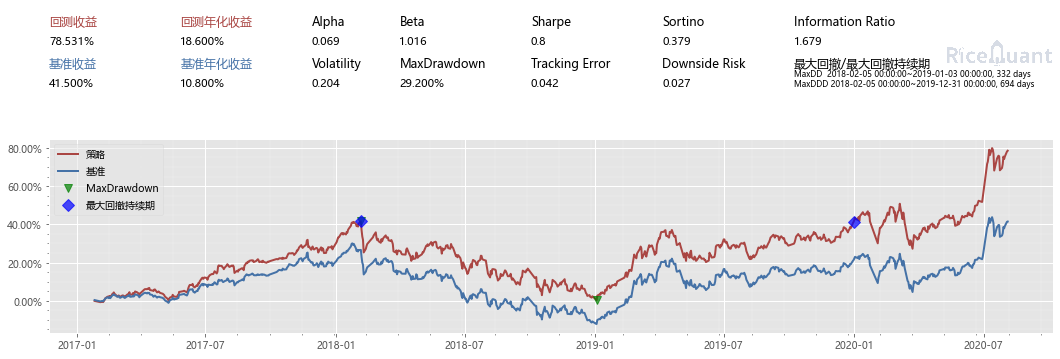

In [13]:
backtest_results = rqalpha_plus.run_func(handle_bar=handle_bar, config=config)

In [10]:
# ==================回测结果分析====================

def cumulative_excess_return(backtest_result):
    strat_portf = backtest_result['sys_analyser']['portfolio']
    benchmark_portf = backtest_result['sys_analyser']['benchmark_portfolio']
    
    strat_return = strat_portf['unit_net_value'].pct_change()
    benchmark_return = benchmark_portf['unit_net_value'].pct_change()
    
    excess_return = strat_return - benchmark_return
    
    return (excess_return).cumsum()+1
    
def stock_position_stats(backtest_result):
    market_value = backtest_result['sys_analyser']['stock_account']['market_value']
    total_value = backtest_result['sys_analyser']['stock_account']['total_value']
    percentage = market_value / total_value
    num_holdings = backtest_result['sys_analyser']['stock_positions'].groupby(level='date').size()
    return pd.DataFrame(
        {'market_value': market_value, 
         'total_value': total_value,
         'percentage': percentage,
         'num_holdings': num_holdings,
        })

<AxesSubplot:title={'center':'Cumulative Excess Return'}, xlabel='date'>

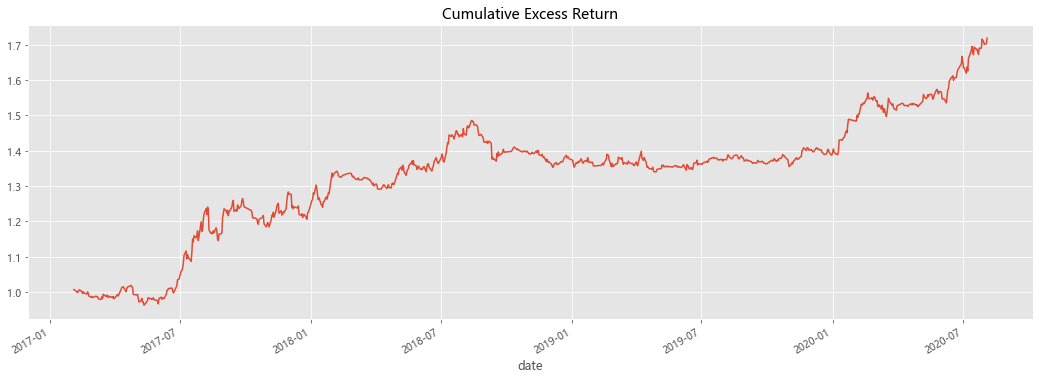

In [12]:
cumulative_excess_return(backtest_results).plot(title='Cumulative Excess Return', figsize=(18, 6))

<AxesSubplot:xlabel='date'>

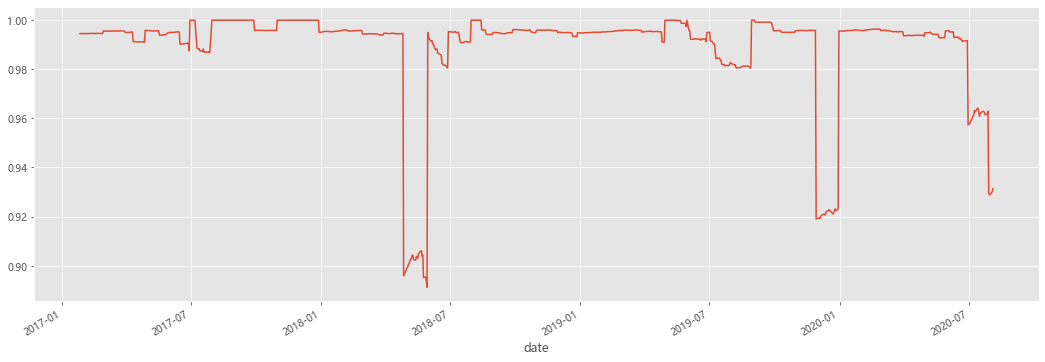

In [13]:
stock_position_stats(backtest_results)['percentage'].plot(figsize=(18, 6))

In [15]:
rqo.portfolio_optimize?